In [51]:
import tensorflow as tf
import tensorflow_datasets as tfds
import joblib

#https://www.tensorflow.org/datasets/keras_example

### Load a dataset

In [52]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:85%]', 'train[85%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


### Build a training and an evaluation pipeline

In [53]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

# Preprocess Training Data
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(int(ds_info.splits['train'].num_examples * 0.85))  # Only shuffle training data
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# Preprocess Validation Data (No shuffle needed)
ds_val = ds_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(128)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

# Preprocess Test Data (No shuffle needed)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


### Create and train the model

In [57]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),  # ensure channel dimension
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)  # from_logits = True in your loss
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
)

Epoch 1/20


/Users/mariiakokina/Downloads/py39env/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.5165 - sparse_categorical_accuracy: 0.8515 - val_loss: 0.0904 - val_sparse_categorical_accuracy: 0.9727
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0715 - val_sparse_categorical_accuracy: 0.9782
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0485 - val_sparse_categorical_accuracy: 0.9848
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0421 - val_sparse_categorical_accuracy: 0.9876
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0519 - val_sparse_categorical_accuracy: 0.9842
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9882
Epoch 7/2

In [58]:
# Evaluate on val set
train_loss, train_acc = model.evaluate(ds_train, verbose=1)

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test, verbose=1)

model.save("../joblib/cnn_model.keras")  # Save as HDF5



399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9990
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9899


In [59]:
# 1. Get Predictions
y_pred_prob = model.predict(ds_test)  # Get predicted probabilities
y_pred = tf.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# 2. Get True Labels from the dataset
y_true = tf.concat([y for _, y in ds_test], axis=0)  # Extract true labels

# 3. Compute Precision, Recall, and F1-score for each class
num_classes = tf.reduce_max(y_true).numpy() + 1  # Get number of classes

for class_id in range(num_classes):
    class_mask = tf.equal(y_true, class_id)  # Mask for current class
    
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    
    # Update metrics only for the current class
    precision.update_state(class_mask, tf.equal(y_pred, class_id))
    recall.update_state(class_mask, tf.equal(y_pred, class_id))
    
    # Compute F1-score manually
    precision_value = precision.result().numpy()
    recall_value = recall.result().numpy()
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + 1e-7))  # Avoid division by zero
    
    print(f"Class {class_id}:")
    print(f"  Precision: {precision_value:.4f}")
    print(f"  Recall:    {recall_value:.4f}")
    print(f"  F1-score:  {f1_value:.4f}")

# 4. Compute Overall Accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy.result().numpy():.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Class 0:
  Precision: 0.9959
  Recall:    0.9918
  F1-score:  0.9939
Class 1:
  Precision: 0.9930
  Recall:    0.9965
  F1-score:  0.9947
Class 2:
  Precision: 0.9874
  Recall:    0.9903
  F1-score:  0.9889
Class 3:
  Precision: 0.9930
  Recall:    0.9822
  F1-score:  0.9876
Class 4:
  Precision: 0.9919
  Recall:    0.9929
  F1-score:  0.9924
Class 5:
  Precision: 0.9790
  Recall:    0.9910
  F1-score:  0.9850
Class 6:
  Precision: 0.9906
  Recall:    0.9916
  F1-score:  0.9911
Class 7:
  Precision: 0.9864
  Recall:    0.9883
  F1-score:  0.9874
Class 8:
  Precision: 0.9837
  Recall:    0.9918
  F1-score:  0.9877
Class 9:
  Precision: 0.9930
  Recall:    0.9782
  F1-score:  0.9855

Overall Accuracy: 0.9895


<Figure size 800x600 with 0 Axes>

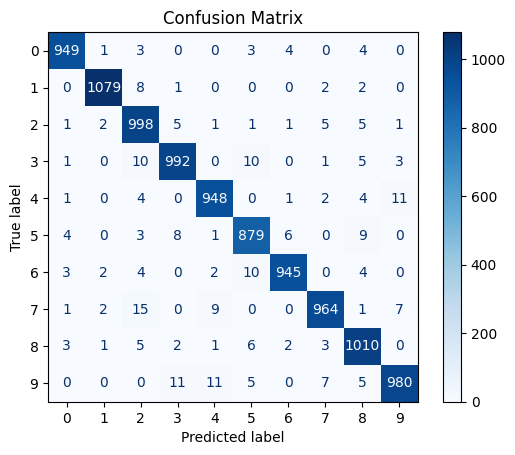

In [16]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set
y_pred = best_model.predict(X_test_std)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
